# Example of DBSCAN & K-Means classification

In [1]:
# Import all the necessary libraries
import numpy as np                                  # For numerical computations
import matplotlib.pyplot as plt                     # For plotting
from matplotlib.colors import ListedColormap        # For coloring the plot
from sklearn.cluster import KMeans, DBSCAN          # For clustering
from sklearn.neighbors import KDTree                # For KDTree
from sklearn.datasets import make_blobs             # For generating synthetic data
from sklearn.preprocessing import StandardScaler    # For scaling the data
from sklearn.metrics import accuracy_score          # For evaluating the clustering
import warnings                                     # For suppressing warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
colors = ['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFA500', '#FF00FF'] # Create a list of colors
cmap_light = ListedColormap(colors) # Create a colormap from the list of colors


## Prepare the data set

In [3]:
n_samples = 400 # Number of samples
n_features = 4
centers = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1]]) # The centers of the clusters
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                  random_state=123, cluster_std=0.3) # Generate isotropic Gaussian blobs for clustering
X = StandardScaler().fit_transform(X) # Standardize the features by removing the mean and scaling to unit variance

In [4]:
idx = np.argsort(y) # Sort the labels
X = X[idx] # Sort the data
y = y[idx] # Sort the labels

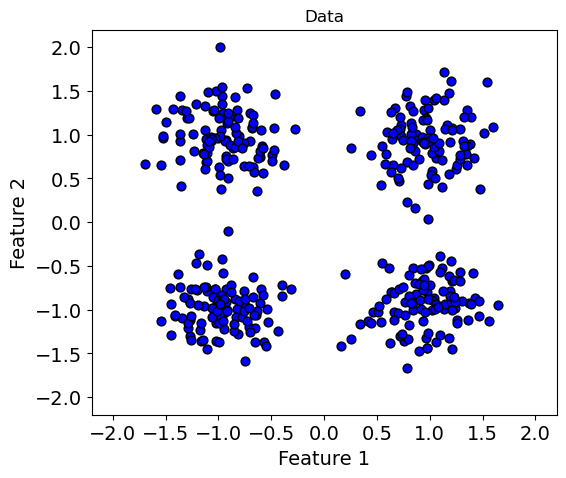

In [5]:
plt.figure(figsize=(6, 5)) # Set the size of the figure
plt.scatter(X[:, 0], X[:, 1], s=40, c='b', edgecolors='k') # Create a scatter plot of the data
plt.xlabel('Feature 1', fontsize=14) # Set the label of the x-axis
plt.ylabel('Feature 2', fontsize=14) # Set the label of the y-axis
plt.xticks(fontsize=14) # Set the font size of the x-axis ticks
plt.yticks(fontsize=14) # Set the font size of the y-axis ticks
plt.xlim(-2.2, 2.2) # Set the limits of the x-axis
plt.ylim(-2.2, 2.2) # Set the limits of the y-axis
plt.title('Data') # Set the title of the plot
plt.show() # Display the plot

## Classification using clustering methods

### K-Means

Accuracy of KMeans: 1.0


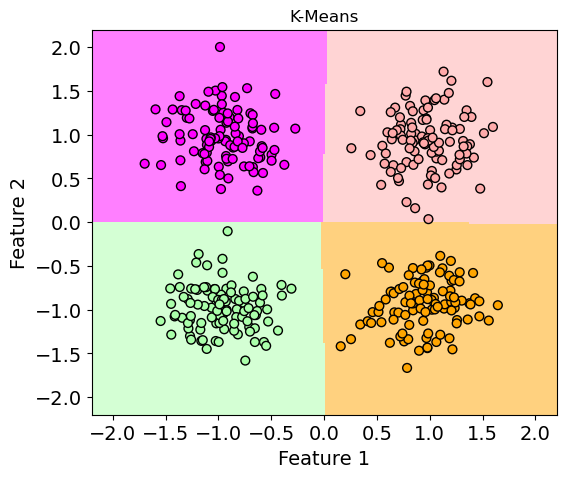

In [6]:
kmeans = KMeans(n_clusters=n_features, init=centers) # Create a KMeans instance
kmeans.fit(X) # Fit the KMeans instance to the data
y_pred = kmeans.labels_ # Get the cluster assignments
accuracy = accuracy_score(y, y_pred) # Compute the accuracy of the clustering
print('Accuracy of KMeans:', accuracy) # Print the accuracy of the clustering

plt.figure(figsize=(6, 5)) # Set the size of the figure
h = 0.02 # Step size of the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # Set the limits of the x-axis
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # Set the limits of the y-axis
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) # Generate a mesh grid
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]) # Predict the closest cluster each sample in the mesh grid belongs to
Z = Z.reshape(xx.shape) # Reshape the predictions

plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.5) # Create a color plot of the mesh grid
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=cmap_light, edgecolors='k') # Create a scatter plot of the data
plt.xlabel('Feature 1', fontsize=14) # Set the label of the x-axis
plt.ylabel('Feature 2', fontsize=14) # Set the label of the y-axis
plt.xticks(fontsize=14) # Set the font size of the x-axis ticks
plt.yticks(fontsize=14) # Set the font size of the y-axis ticks
plt.xlim(-2.2, 2.2) # Set the limits of the x-axis
plt.ylim(-2.2, 2.2) # Set the limits of the y-axis
plt.title('K-Means') # Set the title of the plot
plt.show() # Display the plot

### DBSCAN

Accuracy of DBSCAN: 0.9775


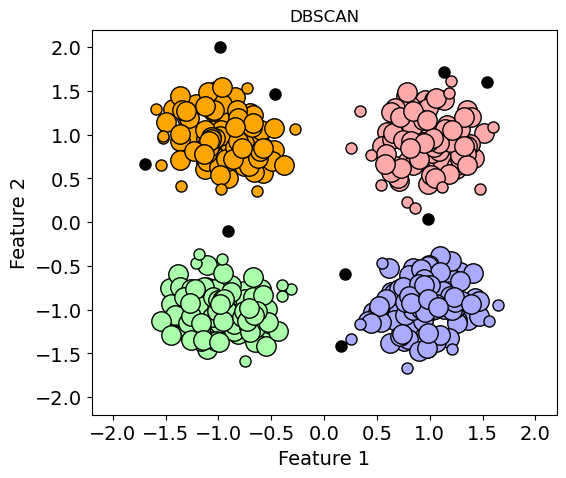

In [7]:
dbscan = DBSCAN(eps=0.3, min_samples=10) # Create a DBSCAN instance
dbscan.fit(X) # Fit the DBSCAN instance to the data
y_pred = dbscan.labels_ # Get the cluster assignments
accuracy = accuracy_score(y, y_pred) # Compute the accuracy of the clustering
print('Accuracy of DBSCAN:', accuracy) # Print the accuracy of the clustering

unique_labels = set(y_pred) # Get the unique cluster assignments
core_samples_mask = np.zeros_like(y_pred, dtype=bool) # Create a boolean array of the same shape as y_pred
core_samples_mask[dbscan.core_sample_indices_] = True # Set the core samples to True

plt.figure(figsize=(6, 5)) # Set the size of the figure
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
    class_member_mask = (y_pred == k)
    xy = X[class_member_mask & core_samples_mask] # Get the core samples
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    xy = X[class_member_mask & ~core_samples_mask] # Get the non-core samples
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=8)
    
plt.xlabel('Feature 1', fontsize=14) # Set the label of the x-axis
plt.ylabel('Feature 2', fontsize=14) # Set the label of the y-axis
plt.xticks(fontsize=14) # Set the font size of the x-axis ticks
plt.yticks(fontsize=14) # Set the font size of the y-axis ticks
plt.xlim(-2.2, 2.2) # Set the limits of the x-axis
plt.ylim(-2.2, 2.2) # Set the limits of the y-axis
plt.title('DBSCAN') # Set the title of the plot
plt.show() # Display the plot

### DBSCAN + KDTree to residual noise

In [8]:
new_labels = y_pred.copy() # Make a copy of the dbscan labels
noise = X[new_labels == -1] # Get noise values
noise_idx = np.where(new_labels == -1)[0] # Get noise indices
non_noise = X[new_labels != -1] # Get non-noise values

# Create the KDTree model and query the nearest neighbors of the noise
kdtree = KDTree(non_noise) # Create a KDTree instance
n_neighbors = 5 # Number of neighbors
_, ind = kdtree.query(noise, k=n_neighbors) # Query the KDTree for the nearest neighbors of the noise

# Get the indices of the nearest neighbors
for i in range(len(noise)):
    labels = y_pred[y_pred != -1][ind[i]] # Get the labels of the nearest neighbors
    label = np.argmax(np.bincount(labels)) # Get the most frequent label
    new_labels[noise_idx[i]] = label # Assign the most frequent label to the noise

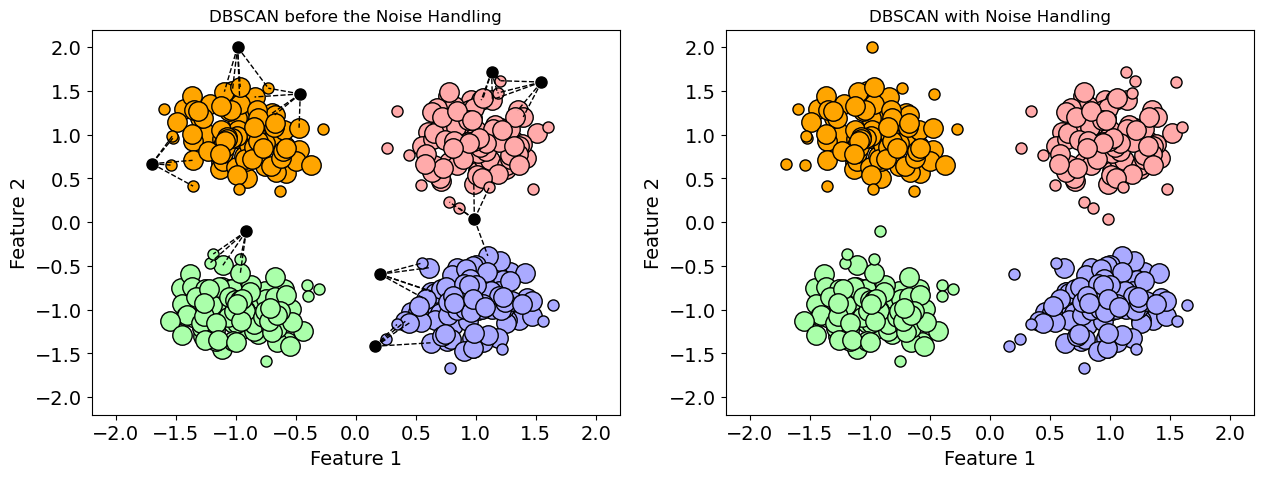

In [9]:
plt.figure(figsize=(15, 5)) # Set the size of the figure
plt.subplot(1, 2, 1) # Create the first subplot
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
    class_member_mask = (y_pred == k) # Create a mask for the class members
    xy = X[class_member_mask & core_samples_mask] # Get the core samples
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    xy = X[class_member_mask & ~core_samples_mask] # Get the non-core samples
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=8)

for i in range(len(noise)):
    for j in range(n_neighbors):
        plt.plot([noise[i, 0], non_noise[ind[i, j], 0]], 
                 [noise[i, 1], non_noise[ind[i, j], 1]], 'k--', lw=1) # Create a line between the noise and its nearest neighbors

plt.xlabel('Feature 1', fontsize=14) # Set the label of the x-axis
plt.ylabel('Feature 2', fontsize=14) # Set the label of the y-axis
plt.xticks(fontsize=14) # Set the font size of the x-axis ticks
plt.yticks(fontsize=14) # Set the font size of the y-axis ticks
plt.xlim(-2.2, 2.2) # Set the limits of the x-axis
plt.ylim(-2.2, 2.2) # Set the limits of the y-axis
plt.title('DBSCAN before the Noise Handling') # Set the title of the plot

plt.subplot(1, 2, 2) # Create the second subplot
unique_labels = set(new_labels) # Get the unique labels
core_samples_mask = np.zeros_like(new_labels, dtype=bool) # Create a mask for the core samples
core_samples_mask[dbscan.core_sample_indices_] = True # Set the mask for the core samples

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
    class_member_mask = (new_labels == k) # Create a mask for the class members
    xy = X[class_member_mask & core_samples_mask] # Get the core samples
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    xy = X[class_member_mask & ~core_samples_mask] # Get the non-core samples
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=8)

plt.xlabel('Feature 1', fontsize=14) # Set the label of the x-axis
plt.ylabel('Feature 2', fontsize=14) # Set the label of the y-axis
plt.xticks(fontsize=14) # Set the font size of the x-axis ticks
plt.yticks(fontsize=14) # Set the font size of the y-axis ticks
plt.xlim(-2.2, 2.2) # Set the limits of the x-axis
plt.ylim(-2.2, 2.2) # Set the limits of the y-axis
plt.title('DBSCAN with Noise Handling') # Set the title of the plot

plt.show() # Display the plot